<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/CLDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the dataset (Copy from CNN.ipynb and merge cells) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [6]:
import pickle
import numpy as np
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)



kooft = np.zeros(shape=(X.shape[0],X.shape[1],X.shape[2]+1))

for i in range(X.shape[0]):
    snr = int(labels[i,1])
    kooft[i,0,:] = np.insert(X[i,0,:],0,snr)
    kooft[i,1,:] = np.insert(X[i,1,:],0,snr)
    

    
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(kooft, y, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)

X_train = X_train[:,:,1:]

y_test18 = []
X_test18 = []

for i in range(X_test.shape[0]):
    if X_test[i,0,0] == 18:
        X_test18.append(X_test[i])
        y_test18.append(y_test[i])
        
X_test18 = np.array(X_test18)
y_test18 = np.array(y_test18)        
X_test18 = X_test18[:,:,1:]

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# StandardScaler expected <= 2.
#X_train = X_train.reshape([6400,256])
X_train = X_train.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test18 = X_test18.reshape([X_test18.shape[0],256])
X_test18 = sc.transform(X_test18)
X_test18 = X_test18.reshape([X_test18.shape[0],2,128])


X_train = X_train.reshape(-1,2, 128, 1)   #Reshape for CNN -  (6400,2,128)->(6400,2,128,1)!!
X_test18 = X_test18.reshape(-1,2, 128, 1)


loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)
SNR : 18


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
print(X_test18.shape)


(1653, 2, 128, 1)


In [0]:
print(X_test.shape)

(32000, 2, 129)


## Import Module

In [0]:
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Reshape

#Making CLDNN0 model
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,(1,3), input_shape =  (2,128,1), activation = 'relu', padding='same')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,(1,3), activation = 'relu', padding='same'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,(1,3), activation = 'relu', padding='same'))
classifier.add(Dropout(rate = dout))
classifier.add(Reshape(target_shape=(126,80)))

classifier.add(LSTM(50))

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="logs", write_graph=True, histogram_freq=5)

classifier.summary()
print("Model Created!")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (2, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 2, 128, 256)       1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 126, 256)       393472    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 126, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 126, 80)        61520     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 126, 80)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 126, 80)        19280     
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=8)`


#Making CLDNN1 model
(Article : Deep Architectures for Modulation Recognition - Timothy J. O’Shea)

# Fitting model

In [0]:
batch = 1024
epoch = 100
history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch, validation_data=(X_test18, y_test18))
#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

# Prediction 

In [0]:
y_pred = classifier.predict(X_test18)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test18, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test18, y_test18)[1]
#acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
#print("Acc Train : ", acc_train)


# Plot Confusion Matrix

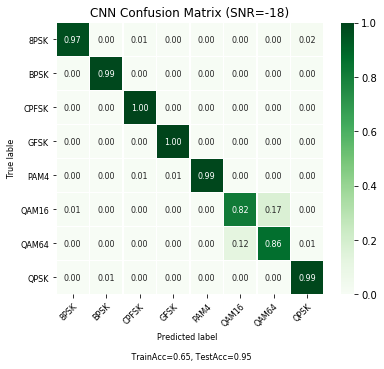

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Greens")

plt.title(f"CNN Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
plt.ylabel("True lable", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
fig = ax.get_figure()

# Save model

In [0]:
dic = "/content/drive/My Drive/Colab Notebooks/"
classifier.save(dic+f'SaveModel/CLDNN-ba{batch}-ep{epoch}(SNR=all).h5')
print('Model Saved!')

Model Saved!
